1.0


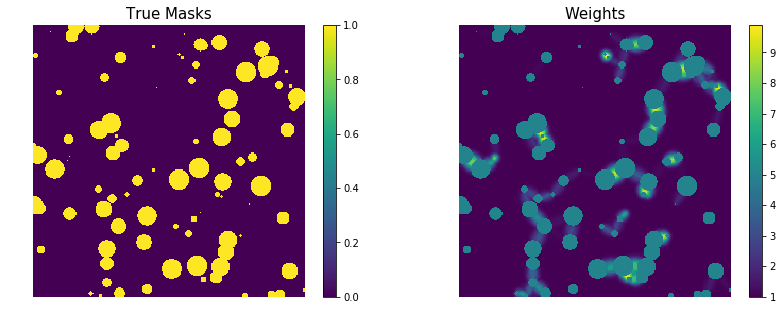

In [1]:
%matplotlib inline
import numpy as np
import skimage.io
from skimage.io import imshow
from skimage.measure import label
from scipy.ndimage.morphology import distance_transform_edt
import matplotlib.pyplot as plt

def generate_random_circles(n = 100, d = 256):
    circles = np.random.randint(0, d, (n, 3))
    x = np.zeros((d, d), dtype=int)
    f = lambda x, y: ((x - x0)**2 + (y - y0)**2) <= (r/d*10)**2
    for x0, y0, r in circles:
        x += np.fromfunction(f, x.shape)
    x = np.clip(x, 0, 1)

    return x

def unet_weight_map(y, wc=None, w0 = 10, sigma = 5):

    """
    Generate weight maps as specified in the U-Net paper
    for boolean mask.

    "U-Net: Convolutional Networks for Biomedical Image Segmentation"
    https://arxiv.org/pdf/1505.04597.pdf

    Parameters
    ----------
    mask: Numpy array
        2D array of shape (image_height, image_width) representing binary mask
        of objects.
    wc: dict
        Dictionary of weight classes.
    w0: int
        Border weight parameter.
    sigma: int
        Border width parameter.

    Returns
    -------
    Numpy array
        Training weights. A 2D array of shape (image_height, image_width).
    """

    labels = label(y)
    no_labels = labels == 0
    label_ids = sorted(np.unique(labels))[1:]

    if len(label_ids) > 1:
        distances = np.zeros((y.shape[0], y.shape[1], len(label_ids)))

        for i, label_id in enumerate(label_ids):
            distances[:,:,i] = distance_transform_edt(labels != label_id)

        distances = np.sort(distances, axis=2)
        d1 = distances[:,:,0]
        d2 = distances[:,:,1]
        w = w0 * np.exp(-1/2*((d1 + d2) / sigma)**2) * no_labels

        if wc:
            class_weights = np.zeros_like(y)
            for k, v in wc.items():
                class_weights[y == k] = v
            w = w + class_weights
    else:
        w = np.zeros_like(y)

    return w

y = generate_random_circles()

wc = {
    0: 1, # background
    1: 5  # objects
}

w = unet_weight_map(y, wc)

#imshow(w)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))
msk = ax1.imshow(y)
ax1.set_axis_off()
ax1.set_title('True Masks', fontsize=15)
_ = fig.colorbar(msk, ax=ax1)
print(np.min(w))
pos = ax2.imshow(w)
ax2.set_axis_off()
ax2.set_title('Weights', fontsize=15)
_ = fig.colorbar(pos, ax=ax2)

In [2]:
mask_srb = skimage.io.imread("./train-all-original/0r1gocrdstw0xgzlkerf_mask.png", dtype=np.float)

wc = {
    0: 1, # background
    1: 5  # objects
}

weight_srb = unet_weight_map(mask_srb//255, wc, w0=15, sigma=5)
print(np.min(weight_srb))

1.0


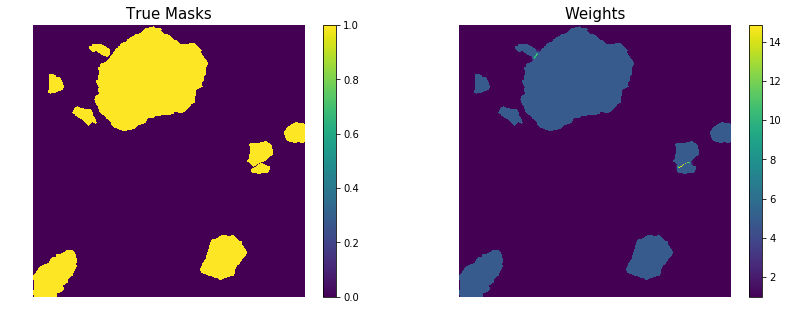

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))
msk = ax1.imshow(mask_srb//255)
ax1.set_axis_off()
ax1.set_title('True Masks', fontsize=15)
_ = fig.colorbar(msk, ax=ax1)

pos = ax2.imshow(weight_srb)
ax2.set_axis_off()
ax2.set_title('Weights', fontsize=15)
_ = fig.colorbar(pos, ax=ax2)
plt.savefig('weights.png', dpi=250)

(700, 700)


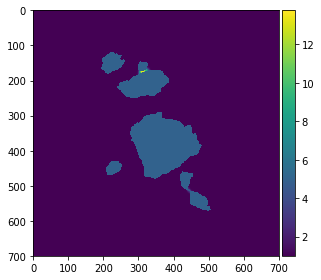

In [14]:
imshow(weight_srb)
print(weight_srb.shape)
skimage.io.imsave('delete.png', weight_srb.astype(np.uint8))